# Remove the comments on the following section to install all the required libraries to run this project.

In [1370]:
# %pip install scikit-learn
# %pip install numpy
# %pip install pandas
# %pip install matplotlib
# %pip install seaborn

## Imports the will be used for the whole project

In [1371]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import linear_model
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score

In [1372]:
### Loading the Dataset
data = pd.read_csv("House_Rent_Dataset.csv")
data

,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact
0,2022-05-18,2,10000,1100,Ground out of 2,Super Area,Bandel,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner
1,2022-05-13,2,20000,800,1 out of 3,Super Area,"Phool Bagan, Kankurgachi",Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
2,2022-05-16,2,17000,1000,1 out of 3,Super Area,Salt Lake City Sector 2,Kolkata,Semi-Furnished,Bachelors/Family,1,Contact Owner
3,2022-07-04,2,10000,800,1 out of 2,Super Area,Dumdum Park,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner
4,2022-05-09,2,7500,850,1 out of 2,Carpet Area,South Dum Dum,Kolkata,Unfurnished,Bachelors,1,Contact Owner
...,...,...,...,...,...,...,...,...,...,...,...,...
4741,2022-05-18,2,15000,1000,3 out of 5,Carpet Area,Bandam Kommu,Hyderabad,Semi-Furnished,Bachelors/Family,2,Contact Owner
4742,2022-05-15,3,29000,2000,1 out of 4,Super Area,"Manikonda, Hyderabad",Hyderabad,Semi-Furnished,Bachelors/Family,3,Contact Owner
4743,2022-07-10,3,35000,1750,3 out of 5,Carpet Area,"Himayath Nagar, NH 7",Hyderabad,Semi-Furnished,Bachelors/Family,3,Contact Agent
4744,2022-07-06,3,45000,1500,23 out of 34,Carpet Area,Gachibowli,Hyderabad,Semi-Furnished,Family,2,Contact Agent


## Data Preprocessing

In [1373]:
data = data[['BHK', 
            # 'Bathroom', 
            'Furnishing Status', 
            # 'Area Type', 
            'City', 
            'Size', 
            'Floor', 
            'Tenant Preferred', 
            'Point of Contact', 
            # 'Area Locality', 
            'Rent']]

In [1374]:
# Give ground and basement floors numerical values
def replace_ground_basement(row):
    if 'Ground' in row:
        return row.replace("Ground", '1')
    elif "Upper Basement" in row:
        return row.replace("Upper Basement", '2')
    elif "Lower Basement" in row:
        return row.replace("Lower Basement", '1')
    else:
        return row

'''   
First thought is to make basement values as negative but changed it eventually to make it count as part of the total floors
'''
# Replace " out of " with '/' to make it easier to evaluate the floors
def replace_out_of(row):
    if " out of " not in row:
        return '1'
    else:
        return row.replace(" out of ", '/')

'''
I created my own evaluate function to handle ZeroDivisionError
'''
def evaluate_fraction(row):
    try:
        return eval(row)
    except ZeroDivisionError:
        return None

# This is to check if there are rows that the left value is greater than the total floor and switch its placement
def check_greater_left_value(row):
    if " out of " in row:
        test = row.split(" out of ")
        if int(test[0]) > int(test[1]):
            print("Before manipulation:", test)
            row = "{} out of {}".format(test[1], test[0])
            print("After manipulation:", test)
            return row
        else:
            return row
    else:
        return row
    
'''
I chose to switch the placement of the floors because I assumed that this happened because of human error
'''

# This is to check if the evaluation of floors resulted in a value greater than 1
def check_gereater_than_1(row):
    if row > 1:
        print(row)
    return row

### Data Cleaning for Floor column

In [1375]:
data['Floor'] = data['Floor'].apply(replace_ground_basement)
data['Floor'] = data['Floor'].apply(check_greater_left_value)
data['Floor'] = data['Floor'].apply(replace_out_of)
data['Floor'] = data['Floor'].apply(evaluate_fraction)
data['Floor'] = data['Floor'].apply(check_gereater_than_1)
data['Floor'].unique()

Before manipulation: ['8', '5']
After manipulation: ['8', '5']
Before manipulation: ['2', '1']
After manipulation: ['2', '1']


C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_29620\1660703832.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Floor'] = data['Floor'].apply(replace_ground_basement)
C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_29620\1660703832.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Floor'] = data['Floor'].apply(check_greater_left_value)
C:\Users\Lex Zedrick Lorenzo\AppData\Local\Temp\ipykernel_29620\1660703832.py:3: SettingWithCopyWarning: 
A value is trying to be set o

array([0.5       , 0.33333333, 1.        , 0.25      , 0.66666667,
       0.8       , 0.4       , 0.28571429, 0.875     , 0.75      ,
       0.2       , 0.625     , 0.16666667, 0.6       , 0.57894737,
       0.78571429, 0.7       , 0.15384615, 0.85714286, 0.57142857,
       0.55128205, 0.72222222, 0.41666667, 0.42857143, 0.5483871 ,
       0.52380952, 0.36842105, 0.60869565, 0.45      , 0.22222222,
       0.79166667, 0.14285714, 0.04545455, 0.06896552, 0.125     ,
       0.90909091, 0.70833333, 0.35714286, 0.35      , 0.71428571,
       0.40909091, 0.59090909, 0.5952381 , 0.6097561 , 0.67948718,
       0.65      , 0.69565217, 0.55555556, 0.76190476, 0.3125    ,
       0.7804878 , 0.1       , 0.61904762, 0.31034483, 0.52808989,
       0.17073171, 0.93333333, 0.86666667, 0.26315789, 0.27272727,
       0.4047619 , 0.83333333, 0.63636364, 0.52941176, 0.26666667,
       0.46666667, 0.05      , 0.27777778, 0.5862069 , 0.63157895,
       0.375     , 0.77272727, 0.53333333, 0.48387097, 0.39285

## One Hot Encoding the columns without numerical value

In [1376]:
def one_hot_encode(data, column, suffix=''):
    encoded = pd.get_dummies(data[column], drop_first= True)
    data = data.drop(column, axis = 1)
    data = data.join(encoded, lsuffix='_data', rsuffix='_encoded')
    # data = data.join(encoded)
    return data

data = one_hot_encode(data, 'Furnishing Status')
data = one_hot_encode(data, 'City')
data = one_hot_encode(data, 'Tenant Preferred')
data = one_hot_encode(data, 'Point of Contact')

## Removing outliers from rent column using z-scores

In [1377]:
z = np.abs(stats.zscore(data['Rent']))
print(z)
threshold_z = 1.7
print("Original DataFrame Shape:", data.shape)
outlier_indices = np.where(z > threshold_z)[0]
data = data.drop(outlier_indices)
print("DataFrame Shape after Removing Outliers:", data.shape)
data

0       0.320026
1       0.191982
2       0.230395
3       0.320026
4       0.352037
          ...   
4741    0.256004
4742    0.076743
4743    0.000084
4744    0.128128
4745    0.256004
Name: Rent, Length: 4746, dtype: float64
Original DataFrame Shape: (4746, 15)
DataFrame Shape after Removing Outliers: (4595, 15)


,BHK,Size,Floor,Rent,Semi-Furnished,Unfurnished,Chennai,Delhi,Hyderabad,Kolkata,Mumbai,Bachelors/Family,Family,Contact Builder,Contact Owner
0,2,1100,0.500000,10000,False,True,False,False,False,True,False,True,False,False,True
1,2,800,0.333333,20000,True,False,False,False,False,True,False,True,False,False,True
2,2,1000,0.333333,17000,True,False,False,False,False,True,False,True,False,False,True
3,2,800,0.500000,10000,False,True,False,False,False,True,False,True,False,False,True
4,2,850,0.500000,7500,False,True,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4741,2,1000,0.600000,15000,True,False,False,False,True,False,False,True,False,False,True
4742,3,2000,0.250000,29000,True,False,False,False,True,False,False,True,False,False,True
4743,3,1750,0.600000,35000,True,False,False,False,True,False,False,True,False,False,False
4744,3,1500,0.676471,45000,True,False,False,False,True,False,False,False,True,False,False


## Training and Test split

In [1378]:
X = data.drop('Rent', axis= 1)
y = data['Rent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=150)

## Standardize the values using PolynomialFeatures

In [1379]:
sc = PolynomialFeatures()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Modelling

In [1380]:
# Test a variety of penalty value using Ridge Cross-Validation to find the most suitable alpha value
alphas = [30, 20, 10, 15, 25, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 175, 200, 225, 250, 275, 300, 400, 500]
sample_model = RidgeCV(alphas=alphas, store_cv_values=True)
sample_model.fit(X_train, y_train)
optimal_alpha = sample_model.alpha_
print(optimal_alpha)

# model = linear_model.LinearRegression()
model = linear_model.Ridge(alpha=optimal_alpha)
model.fit(X_train, y_train)
model.coef_

70


array([ 0.00000000e+00, -6.52663156e+01,  2.82866057e+01, -2.58537921e+01,
       -9.83378989e+02, -5.10773691e+02,  1.04870057e+03, -4.28327896e+02,
        2.40752859e+02,  2.48641243e+02,  2.20984351e+02,  7.13797507e+02,
       -1.34085548e+03, -2.26942109e-02,  4.99981989e+02,  1.24632652e+03,
       -2.17007697e+00,  1.73259034e+03,  8.26360309e+02,  3.10136624e+02,
        8.92621286e+02,  3.20098192e+03,  5.24544313e+02, -6.91906588e-01,
        3.14450243e+02, -5.22029167e+01, -1.45244931e+03, -2.26942109e-02,
       -1.39740800e+03,  3.31957528e-03, -1.88954704e+00, -6.06845653e+00,
       -8.10715528e+00, -3.25248842e+00, -1.22745952e+00, -6.07123851e+00,
       -8.81943014e+00,  4.68869009e+01, -1.86258607e+00,  3.40724564e+00,
       -9.07768435e+00, -8.66239025e+00,  8.21992520e+02,  1.45404706e+01,
       -9.69371362e+02, -1.05017826e+02,  4.00032749e+02,  4.32788880e+02,
       -2.03221939e+02,  5.76165435e+02, -5.52752881e+02, -4.53007849e+02,
       -1.13471054e-02, -

# Evaluation

## Quantitative Evaluation

In [1381]:
print(f"Regression-Training set score: {model.score(X_train, y_train):.2f}")
print(f"Regression-Test set score: {model.score(X_test, y_test):.2f}")

Regression-Training set score: 0.75
Regression-Test set score: 0.80


In [1382]:
### Quantitative Evaluation
y_preds = model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score

# The coefficients
print("Coefficients: \n", model.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_preds))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_preds))

Coefficients: 
 [ 0.00000000e+00 -6.52663156e+01  2.82866057e+01 -2.58537921e+01
 -9.83378989e+02 -5.10773691e+02  1.04870057e+03 -4.28327896e+02
  2.40752859e+02  2.48641243e+02  2.20984351e+02  7.13797507e+02
 -1.34085548e+03 -2.26942109e-02  4.99981989e+02  1.24632652e+03
 -2.17007697e+00  1.73259034e+03  8.26360309e+02  3.10136624e+02
  8.92621286e+02  3.20098192e+03  5.24544313e+02 -6.91906588e-01
  3.14450243e+02 -5.22029167e+01 -1.45244931e+03 -2.26942109e-02
 -1.39740800e+03  3.31957528e-03 -1.88954704e+00 -6.06845653e+00
 -8.10715528e+00 -3.25248842e+00 -1.22745952e+00 -6.07123851e+00
 -8.81943014e+00  4.68869009e+01 -1.86258607e+00  3.40724564e+00
 -9.07768435e+00 -8.66239025e+00  8.21992520e+02  1.45404706e+01
 -9.69371362e+02 -1.05017826e+02  4.00032749e+02  4.32788880e+02
 -2.03221939e+02  5.76165435e+02 -5.52752881e+02 -4.53007849e+02
 -1.13471054e-02 -2.13448803e+03 -9.83378989e+02  0.00000000e+00
 -3.66432159e+02 -9.43658146e+02  1.11017150e+03  7.75092988e+02
  3.27811

## Qualitative Evaluation

In [1383]:
### Qualitative Evaluation
sample_data = X.iloc[0]

sample_data_standardized = sc.transform(X.iloc[0].values.reshape(1,-1))
sample_data_standardized

c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


array([[1.00e+00, 2.00e+00, 1.10e+03, 5.00e-01, 0.00e+00, 1.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 1.00e+00,
        0.00e+00, 0.00e+00, 1.00e+00, 4.00e+00, 2.20e+03, 1.00e+00,
        0.00e+00, 2.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 2.00e+00,
        0.00e+00, 2.00e+00, 0.00e+00, 0.00e+00, 2.00e+00, 1.21e+06,
        5.50e+02, 0.00e+00, 1.10e+03, 0.00e+00, 0.00e+00, 0.00e+00,
        1.10e+03, 0.00e+00, 1.10e+03, 0.00e+00, 0.00e+00, 1.10e+03,
        2.50e-01, 0.00e+00, 5.00e-01, 0.00e+00, 0.00e+00, 0.00e+00,
        5.00e-01, 0.00e+00, 5.00e-01, 0.00e+00, 0.00e+00, 5.00e-01,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 1.00e+00,
        0.00e+00, 0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 

In [1384]:
model_rent_forecast = model.predict(sample_data_standardized)[0]
model_rent_forecast

print(f'Rent forecast made by the model: {model_rent_forecast}')
print(f'Actual rent: {y.iloc[0]}')

Rent forecast made by the model: 9336.475960032607
Actual rent: 10000


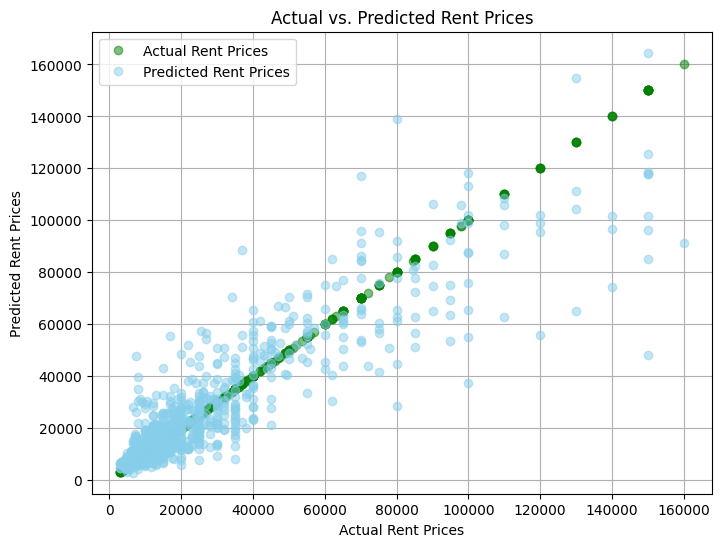

In [1385]:
plt.figure(figsize=(8,6))
plt.plot(y_test, y_test, 'o', alpha=0.5, color='green', label='Actual Rent Prices')
plt.plot(y_test, y_preds, 'o', alpha=0.5, color='skyblue', label='Predicted Rent Prices')

plt.title("Actual vs. Predicted Rent Prices")
plt.xlabel("Actual Rent Prices")
plt.ylabel("Predicted Rent Prices")

plt.legend()
plt.grid(True)
plt.show()